In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

In [3]:
ratings = pd.read_csv('Datasets/ratings.csv')
movies = pd.read_csv('Datasets/movies.csv')
tags = pd.read_csv('Datasets/tags.csv')
links = pd.read_csv('Datasets/links.csv')

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077.0
1,1,25,1.0,944250228.0
2,1,29,2.0,943230976.0
3,1,30,5.0,944249077.0
4,1,32,5.0,943228858.0


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1.583039e+09
1,22,79592,misogyny,1.581476e+09
2,22,247150,acrophobia,1.622483e+09
3,34,2174,music,1.249808e+09
4,34,2174,weird,1.249808e+09


In [7]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
# Spliting the genres column into multiple columns and encoding them
movies['genres'] = movies['genres'].str.split('|')
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies = movies.join(genres_df)

In [9]:
# Convert the timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year

In [10]:
# Normalize the ratings
scaler = MinMaxScaler()
ratings['rating_normalized'] = scaler.fit_transform(ratings['rating'].values.reshape(-1, 1))

In [11]:
# Filter out movies with less than 5 ratings
min_movie_ratings = 5
movie_counts = ratings['movieId'].value_counts()
ratings = ratings[ratings['movieId'].isin(movie_counts[movie_counts >= min_movie_ratings].index)]

In [12]:
print("Ratings Dataframe Details")
print(ratings.shape)
print(ratings.info())

Ratings Dataframe Details
(270914, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 270914 entries, 0 to 288960
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   userId             270914 non-null  int64         
 1   movieId            270914 non-null  int64         
 2   rating             270913 non-null  float64       
 3   timestamp          270913 non-null  datetime64[ns]
 4   year               270913 non-null  float64       
 5   rating_normalized  270913 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 14.5 MB
None


In [13]:
print("Movies Dataframe Details")
print(movies.shape)
print(movies.info())

Movies Dataframe Details
(87585, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieId             87585 non-null  int64 
 1   title               87585 non-null  object
 2   genres              87585 non-null  object
 3   (no genres listed)  87585 non-null  int64 
 4   Action              87585 non-null  int64 
 5   Adventure           87585 non-null  int64 
 6   Animation           87585 non-null  int64 
 7   Children            87585 non-null  int64 
 8   Comedy              87585 non-null  int64 
 9   Crime               87585 non-null  int64 
 10  Documentary         87585 non-null  int64 
 11  Drama               87585 non-null  int64 
 12  Fantasy             87585 non-null  int64 
 13  Film-Noir           87585 non-null  int64 
 14  Horror              87585 non-null  int64 
 15  IMAX                87585 non-nul

In [14]:
counts = ratings['movieId'].value_counts()
counts

,count
movieId,
318,952
356,908
296,896
2571,874
593,828
...,...
1746,5
2483,5
2765,5


In [15]:

from scipy.sparse import coo_matrix

# Create the user-item matrix using sparse format
user_item_matrix_sparse = coo_matrix((ratings['rating'], (ratings['userId'], ratings['movieId'])))


In [16]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [17]:
from surprise import Dataset, Reader, SVD
from surprise import accuracy

# Define the reader for the dataset
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

# Load the train and test data
train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader).build_full_trainset()
test_data = list(zip(test['userId'], test['movieId'], test['rating']))


In [18]:
# Initialize and train the SVD model
svd = SVD()
svd.fit(train_data)

In [19]:
# Make predictions on the test set
predictions = [svd.predict(uid=row[0], iid=row[1], r_ui=row[2]) for row in test_data]

# Calculate RMSE without reusing the name
test_rmse = accuracy.rmse(predictions, verbose=True)
print(f"Test RMSE: {test_rmse}")

RMSE: 1.7882
Test RMSE: 1.7881818318849751


In [23]:
def recommend_movies(user_id, svd, movies, ratings, top_n=10):
    # Get all movie IDs
    all_movies = set(movies['movieId'])

    # Get movies already rated by the user
    rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])

    # Predict ratings for unseen movies
    unseen_movies = all_movies - rated_movies
    predictions = [(movie, svd.predict(user_id, movie).est) for movie in unseen_movies]

    # Sort movies by predicted rating
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]

    # Map back to movie titles
    recommended_movie_titles = [movies[movies['movieId'] == movie].iloc[0]['title'] for movie, _ in recommendations]
    return recommended_movie_titles

# Example usage
user_id = 1554
top_movies = recommend_movies(user_id, svd, movies, ratings, top_n=10)
print(f"Top recommended movies for User {user_id}: {top_movies}")


Top recommended movies for User 1554: ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)', 'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)', 'Sudden Death (1995)', 'GoldenEye (1995)']


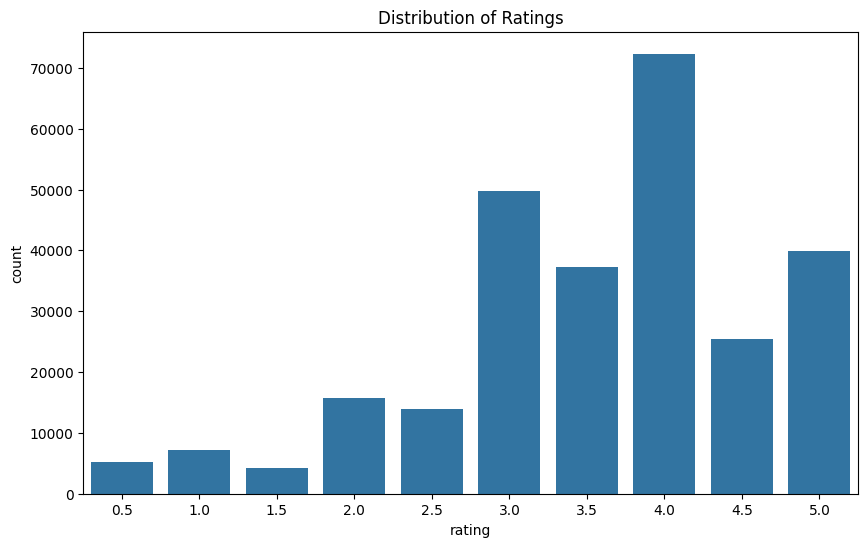

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

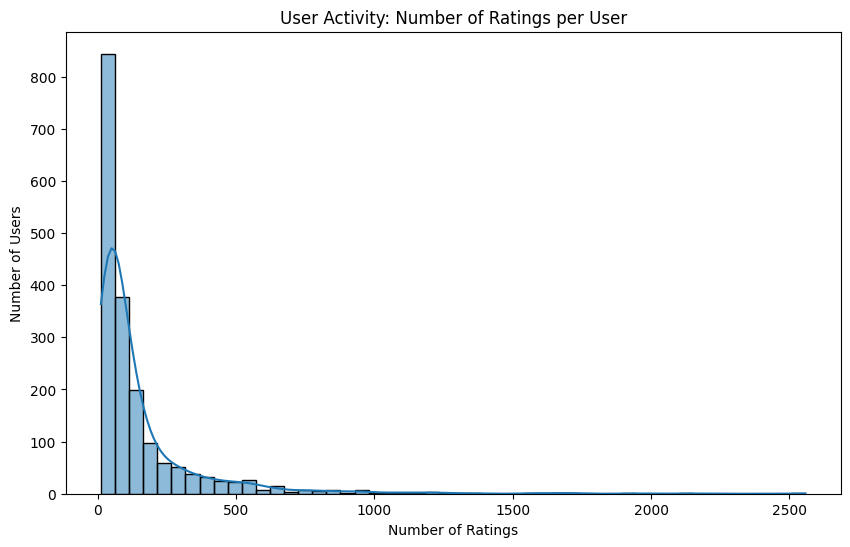

In [25]:
user_activity = ratings.groupby('userId').size()
plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=50, kde=True)
plt.title('User Activity: Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()